# Show plots for blocklisting work, an submission backlog

In [ ]:
# small tips 
# ! pip install ads plotly pandas
# look at https://ads.readthedocs.io/en/latest/#getting-started

## Prepare list of libraries 

In [1]:
lists={
    "blocklist":{"id":"lRAwFv_1Q-6J9ZAGrW_hHA", "color":"red"},
    "refereed":{"id":"KusGHVjTSxu1Loo1obbF9A", "color":"green"},
    "jmmc-non-interfero":{"id":"SQOGeFmDTjOf6jZ5bepqPQ", "color":"orange"},
}

## Collect metadata (number of documents)

In [2]:
import ads 
from ads import libraries

for name,d in lists.items():
    id=d["id"]
    d["metadata"]=libraries.Library(id).metadata


## Use Ads facets to create dataframes with number of docs per year

In [3]:
import pandas as pd

sq = ads.SearchQuery(q="docs(library/KusGHVjTSxu1Loo1obbF9A)")

for name,d in lists.items():    
    query = "docs(library/"+d["id"]+")"
    # query ads hacking facet params
    q = ads.SearchQuery(q=f'{query}', fl=['bibcode'], rows=2000, max_pages=10)
    params={"facet":"true","facet.pivot":"year",'rows': 0,}
    for k,v in params.items():
        q.query[k]=v
    q.execute()    
    # store results as dataframes    
    d["by_year"]=pd.DataFrame([{ 'year': int(d['value']), 'count': d['count'] } for d in q.response.json['facet_counts']['facet_pivot']['year'] ])        

## Do plots

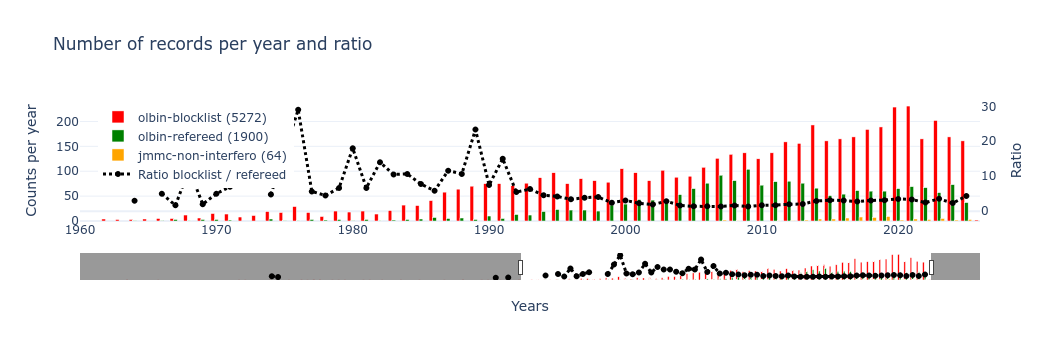

In [7]:
import plotly.graph_objects as go

from_year=1960
fig = go.Figure()

for name,d in lists.items():
    df=d["by_year"]
    fig.add_trace(go.Bar(x=df['year'],y=df['count'], name=f"{d['metadata']['name']} ({d['metadata']['num_documents']})", marker_color=d["color"]))

df = pd.merge(lists["refereed"]["by_year"], lists["blocklist"]["by_year"],on='year', how='outer').fillna(0).sort_values('year')
df['ratio'] = df['count_y'] / df['count_x'].replace(0, pd.NA)
fig.add_trace(go.Scatter(x=df['year'], y=df['ratio'],name='Ratio blocklist / refereed',mode='lines+markers',line=dict(color='black', width=3, dash='dot'),yaxis='y2'))

fig.update_layout(
    title='Number of records per year and ratio',
    xaxis=dict(range=[from_year,df['year'].max()], title='Years',rangeslider=dict(visible=True),type='linear'),
    yaxis=dict(title='Counts per year', side='left'),
    yaxis2=dict(title='Ratio',overlaying='y',side='right',showgrid=False),
    barmode='group',
    template='plotly_white',
    legend=dict(x=0.02, y=0.98)
)
fig.show()

#fig.write_html("rejection_plot.html", include_plotlyjs='cdn', full_html=True)

## Collect Olbin database

## Collect olbin data

In [12]:
import xml.etree.ElementTree as ET
from urllib.request import urlopen 

# Parse xml
xml=urlopen("https://publications.olbin.org/xml")
xml_data = xml.read().decode('utf8')
root = ET.fromstring(xml_data)

# Extract pubdate and subdate to build a dataframe
records = [{"pubdate": e.findtext("pubdate"), "subdate": e.findtext("subdate")} for e in root.findall(".//e")]    
bibdbdf = pd.DataFrame(records)
bibdbdf = bibdbdf.dropna(subset=["pubdate", "subdate"])

## Plot pubdate vs subdate 

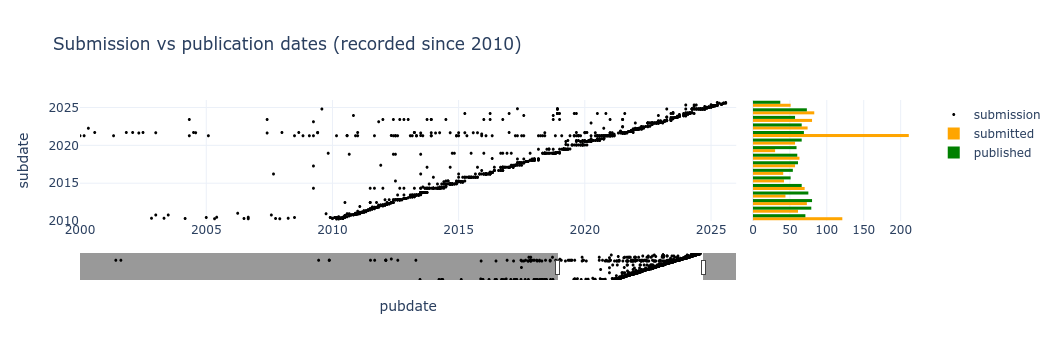

In [14]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2,column_widths=[0.8, 0.2],shared_yaxes=True,horizontal_spacing=0.02)
xaxis_title="pubdate"
yaxis_title="subdate"

#fig.add_trace(go.Histogram2dContour(x=bibdbdf[yaxis_title],y=bibdbdf[yaxis_title],colorscale="YlOrBr",contours=dict(showlines=False),showscale=True, name="Density"))
fig.add_trace(go.Scatter(x=bibdbdf[xaxis_title],y=bibdbdf[yaxis_title],mode="markers",marker=dict(size=3, color="black"), name="submission"), 
    row=1, col=1)
fig.add_trace( go.Histogram(y=bibdbdf[yaxis_title],nbinsy=200, marker=dict(color="orange"), name="submitted"), row=1, col=2 )
fig.add_trace( go.Histogram(y=bibdbdf[xaxis_title],nbinsy=200,marker=dict(color="green"), name="published"), row=1, col=2 )

fig.update_layout(title="Submission vs publication dates (recorded since 2010)",
                  xaxis=dict(range=["2000-01-01","2025-12-31"],title=xaxis_title,rangeslider=dict(visible=True)),
                  yaxis=dict(range=["2010-01-01","2025-12-31"],title=yaxis_title),template="plotly_white")
fig.show()
#fig.write_html("submission_plot.html", include_plotlyjs='cdn', full_html=True)